In [43]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
from scipy.spatial import ConvexHull, distance
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
rc['grid.linewidth']=0


In [66]:
xyz=np.load('../../data/SAC/sample_trajs/sample_traj_SAC_T200.0_F2.0_Ta2.0_Esoft4.0_R020_Na1200_blocksize100_kb10.0_dt0.001_kr30.0_positions.npy')
# xyz=xyz[:,50:200,:]
# xyz=np.load('../sim_codes/test_out/traj_test_positions.npy')
print(xyz.shape)


(2000, 1200, 3)


In [7]:
seq=np.loadtxt('../sim_codes/input_files/chr_seq_AB.txt', dtype=str)
colors=[]
for val in seq:
    # if not 49<int(val[0])<200: pass
    if val[1]=='A': colors.append('r')
    else: colors.append('C0')

print(len(colors))

500


In [10]:
%matplotlib ipympl

fig = plt.figure()
# ax = fig.add_axes([0.,0.5,0.45,0.45],projection='3d')
ax = fig.add_axes([0,0,1,1],projection='3d')

N=500

R0=10
Rx=(-R0,R0)
Ry=(-R0,R0)
Rz=(-R0,R0)

zx=Rx[0]#rcm[0]
zy=Ry[1]#rcm[1]
zz=Rz[0]#rcm[2]

ax.scatter(xyz[0,:N,0],xyz[0,:N,1],xyz[0,:N,2],'o',color=colors)

rval=np.linspace(-R0,R0,200)

ax.plot(rval,np.sqrt(R0**2-rval**2),'k-',zdir='x', zs=Rx[0],lw=0.5)#,c=val[2])

ax.set_xlim(Rx)
ax.set_ylim(Ry)
ax.set_zlim(Rz)
azim=40
elev=29
ax.view_init(azim,elev)
# fig.tight_layout()

def update(ii):
    fig.clear()
    ax = fig.add_axes([0,0,1,1],projection='3d')

    p=xyz[ii]
    
    # for val in [('x',zx,'b', (1,2)),('y',zy,'b',(0,2)),('z',zz,'b',(0,1))]:
    #     print(p[:N,val[3][0]].shape, len(colors))
    #     ax.scatter(p[:N,val[3][0]],p[:N,val[3][1]], zdir=val[0], zs=val[1], c=colors,s=10)
        
    #     ax.plot(rval,np.sqrt(R0**2-rval**2),'k-',zdir=val[0], zs=val[1],lw=0.5)#,c=val[2])
    #     ax.plot(rval,-np.sqrt(R0**2-rval**2),'k-',zdir=val[0], zs=val[1],lw=0.5)#, c=val[2])
    
    ax.plot3D(p[:N,0],p[:N,1],p[:N,2],'-',color='k',lw=0.5)
    ax.scatter(p[:N,0],p[:N,1],p[:N,2],'o',color=colors,s=120)

    ax.set_zlim(Rz)
    ax.set_xlim(Rx)
    ax.set_ylim(Ry)
    ax.text2D(0.05, 0.8, "{}".format(ii), transform=ax.transAxes)

update(10)
ani = FuncAnimation(fig, update, frames=np.arange(1,2000,5), interval=200, blit=True,repeat=False)

# ani.save('ani_RC100_T0p5_F1_Ta10_kb5_R0100_full.gif', writer='pillow')
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

../../data/SAC/sample_trajs/sample_traj_SAC_T200.0_F0.0_Ta1.0_Esoft4.0_R020_Na1200_blocksize100_kb10.0_dt0.001_kr30.0_positions.npy
../../data/SAC/sample_trajs/sample_traj_SAC_T200.0_F1.0_Ta2.0_Esoft4.0_R020_Na1200_blocksize100_kb10.0_dt0.001_kr30.0_positions.npy


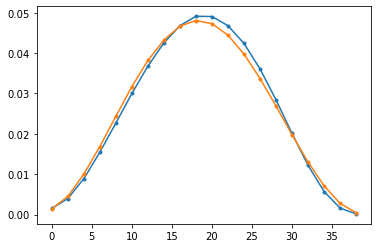

In [91]:
%matplotlib inline
val=['../../data/SAC/sample_trajs/sample_traj_SAC_T200.0_F0.0_Ta1.0_Esoft4.0_R020_Na1200_blocksize100_kb10.0_dt0.001_kr30.0_positions.npy',
    '../../data/SAC/sample_trajs/sample_traj_SAC_T200.0_F1.0_Ta2.0_Esoft4.0_R020_Na1200_blocksize100_kb10.0_dt0.001_kr30.0_positions.npy',]
#    '../../data/SAC/sample_trajs/sample_traj_SAC_T200.0_F2.0_Ta2.0_Esoft4.0_R020_Na1200_blocksize100_kb10.0_dt0.001_kr30.0_positions.npy',
#    '../../data/SAC/sample_trajs/sample_traj_SAC_T200.0_F1.0_Ta200.0_Esoft4.0_R020_Na1200_blocksize100_kb10.0_dt0.001_kr30.0_positions.npy']

for fn in val:
    xyz=np.load(fn)
    dist_all=[]
    print(fn)
    for pos in xyz[:300]:
        dist=distance.cdist(pos,pos, 'euclidean')
        dist_all.append(np.ravel(dist))
    dist_all=np.ravel(dist_all)    
    hist,bins=np.histogram(dist_all, bins=np.arange(0,42,2), density=True)
    plt.plot(bins[:-1], hist,'.-')
# plt.semilogy()
# plt.ylim(1e-4,1e-1)
# plt.xlim(0,7)

In [81]:
poly1=xyz[0,:100,:]
hull=ConvexHull(poly1)

In [17]:
fig=plt.figure()
axi=fig.add_axes([0,0,0.8,0.8],projection='3d')

for simplex in hull.simplices:
    tri = Poly3DCollection(poly1[simplex])
    tri.set_color('b')
    tri.set_alpha(0.5)
    tri.set_edgecolor('k')
    axi.add_collection3d(tri)
axi.scatter(poly1[:,0],poly1[:,1],poly1[:,2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [58]:
def autocorrFFT(x):
    N=len(x)
    F = np.fft.fft(x,n=2*N)  #2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   
    # n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
    return res/(N-np.arange(0,N)) #this is the autocorrelation in convention A

#r is an (T,3) ndarray: [time stamps,dof]
def msd_fft(r):
    N=len(r)
    D=np.square(r).sum(axis=1)
    D=np.append(D,0)
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=[]
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1.append(Q/(N-m))
    return np.array(S1) - 2*S2

In [59]:
d1=msd_fft(xyz[:20,0,:])
print(d1)

[ 0.          1.6366861   2.85522743  3.55156537  4.25256764  4.94496162
  5.17026927  5.90420385  7.01804853  8.98931395 10.2192749  11.9409824
 13.08291883 14.40406205 15.46976339 17.71912129 18.91299827 16.3943899
 13.35601067 12.57748312]


In [47]:
d2=msd_fft(xyz[:10,0,:])

10 (10,) (10,) (10,)
10 (10,) (10,) (10,)
10 (10,) (10,) (10,)


In [65]:
c=np.array([1,2,3])
d=np.tile(c,(100,1,1))
d.shape

(100, 1, 3)

In [37]:
d=np.loadtxt('../sim_codes/input_files/chr_seq_AB.txt', dtype=str)
d.shape
print(d)

[['1' 'B']
 ['2' 'B']
 ['3' 'B']
 ['4' 'B']
 ['5' 'B']
 ['6' 'B']
 ['7' 'B']
 ['8' 'B']
 ['9' 'B']
 ['10' 'B']
 ['11' 'B']
 ['12' 'B']
 ['13' 'B']
 ['14' 'B']
 ['15' 'B']
 ['16' 'B']
 ['17' 'B']
 ['18' 'B']
 ['19' 'A']
 ['20' 'A']
 ['21' 'A']
 ['22' 'A']
 ['23' 'B']
 ['24' 'B']
 ['25' 'B']
 ['26' 'B']
 ['27' 'B']
 ['28' 'B']
 ['29' 'B']
 ['30' 'B']
 ['31' 'B']
 ['32' 'B']
 ['33' 'B']
 ['34' 'B']
 ['35' 'B']
 ['36' 'B']
 ['37' 'B']
 ['38' 'B']
 ['39' 'B']
 ['40' 'B']
 ['41' 'B']
 ['42' 'B']
 ['43' 'B']
 ['44' 'B']
 ['45' 'B']
 ['46' 'B']
 ['47' 'B']
 ['48' 'B']
 ['49' 'B']
 ['50' 'B']
 ['51' 'B']
 ['52' 'B']
 ['53' 'B']
 ['54' 'B']
 ['55' 'B']
 ['56' 'B']
 ['57' 'B']
 ['58' 'B']
 ['59' 'B']
 ['60' 'B']
 ['61' 'B']
 ['62' 'B']
 ['63' 'A']
 ['64' 'A']
 ['65' 'B']
 ['66' 'B']
 ['67' 'B']
 ['68' 'B']
 ['69' 'B']
 ['70' 'B']
 ['71' 'B']
 ['72' 'B']
 ['73' 'B']
 ['74' 'B']
 ['75' 'B']
 ['76' 'B']
 ['77' 'A']
 ['78' 'A']
 ['79' 'A']
 ['80' 'A']
 ['81' 'A']
 ['82' 'A']
 ['83' 'B']
 ['84' 'B']
 

In [93]:
1200**2

1440000